In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from tensorflow import keras
import os
import matplotlib.ticker as mticker
from pyod.models.ocsvm import OCSVM
from pyod.models.gmm import GMM
from pyod.models.lof import LOF

In [ ]:
### ADJUST PATH HERE
name = "banana"
X = pd.read_csv(f"experiments/synthetic_data/{name}.csv", header=None)
X_full = pd.read_csv(f"experiments/synthetic_data/data_with_noise/{name}.csv", header=None)
X_norm = X
with tf.device('/device:GPU:0'):
    model = tf.keras.models.load_model(f"trained_models/{name}/disc_0.keras")

In [3]:
x_min, x_max = X.min()[0] - 0.05,  X.max()[0] + 0.05
y_min, y_max = X.min()[1] - 0.05, X.max()[1] + 0.05
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
output = [xx.ravel().tolist(),yy.ravel().tolist()]
keras.utils.set_random_seed(777) #seeds numpy, random and tf all at once
os.environ["PYTHONHASSEED"] = str(777)
for i in range(58):
    output.append((0*np.ones(len(output[0]))).tolist())
    #output.append(np.random.normal(0,1,len(output[0])).tolist())
output

[[-1.120951929402615,
  -1.1095592045535698,
  -1.098166479704525,
  -1.08677375485548,
  -1.075381030006435,
  -1.06398830515739,
  -1.052595580308345,
  -1.0412028554593,
  -1.0298101306102552,
  -1.01841740576121,
  -1.0070246809121652,
  -0.9956319560631203,
  -0.9842392312140753,
  -0.9728465063650302,
  -0.9614537815159854,
  -0.9500610566669403,
  -0.9386683318178954,
  -0.9272756069688504,
  -0.9158828821198055,
  -0.9044901572707604,
  -0.8930974324217156,
  -0.8817047075726705,
  -0.8703119827236256,
  -0.8589192578745806,
  -0.8475265330255356,
  -0.8361338081764906,
  -0.8247410833274457,
  -0.8133483584784007,
  -0.8019556336293557,
  -0.7905629087803108,
  -0.7791701839312658,
  -0.7677774590822208,
  -0.7563847342331759,
  -0.7449920093841309,
  -0.7335992845350859,
  -0.722206559686041,
  -0.710813834836996,
  -0.699421109987951,
  -0.6880283851389061,
  -0.6766356602898611,
  -0.6652429354408161,
  -0.6538502105917712,
  -0.6424574857427261,
  -0.6310647608936812,
  -0

In [89]:
import ast
subspaces = pd.read_csv("subspaces.txt", delimiter=";", header=None)
for i in range(len(subspaces[0])):
    subspaces[0][i] = ast.literal_eval(subspaces[0][i])
fegan = []
with tf.device('/device:GPU:0'):
    for i in range(14):
        fegan.append(tf.keras.models.load_model(f"trained_models/{name}/disc_{i}.keras"))
train = pd.DataFrame(output).T
with tf.device('/device:GPU:0'):
    Z = fegan[0].predict(train.iloc[:,subspaces[0][0]])
    for i in range(1,14):
        Z +=  fegan[i].predict(train.iloc[:, subspaces[0][i]]) #Probability of being an inlier 
    Z /= 14
    Z

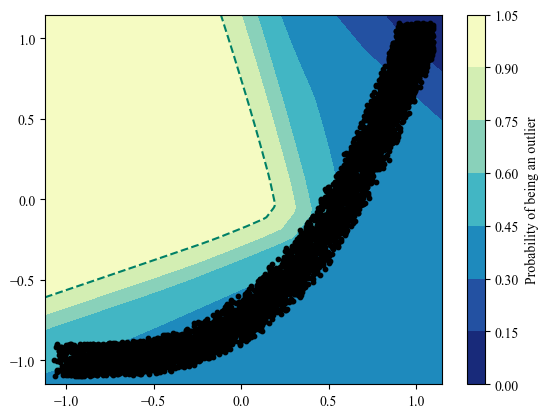

In [106]:
Z = Z.reshape(xx.shape)
Z_final = 1-Z
Z_final = (Z_final-np.min(Z_final))/(np.max(Z_final)-np.min(Z_final))
hfont = {'fontname':'Times New Roman'}
plt.contourf(xx, yy, Z_final, cmap="YlGnBu_r")
plt.colorbar(label = "Probability of being an outlier")
plt.contour(xx,yy,Z_final,levels=[0.9], linestyles = "dashed", cmap = "summer")
plt.scatter(X.iloc()[:, 0], X.iloc()[:, 1], s=10,color='black')
plt.savefig(f"experiments/heatmaps/{name}/GSAAL_boundaries.pdf", bbox_inches='tight')
plt.show()

In [ ]:
#import ast
#subspaces = pd.read_csv("subspaces.txt", delimiter=";", header=None)
#for i in range(len(subspaces[0])):
#    subspaces[0][i] = ast.literal_eval(subspaces[0][i])
#fegan = []
#with tf.device('/device:GPU:1'):
#    for i in range(14):
#        fegan.append(tf.keras.models.load_model(f"trained_models/{name}/disc_{i}.keras"))
#train = pd.DataFrame(output).T
#with tf.device('/device:GPU:1'):
 #   Z = fegan[0].predict(train.iloc[:,subspaces[0][0]])
#    for i in range(1,14):
#        Z +=  fegan[i].predict(train.iloc[:, subspaces[0][i]]) #Probability of being an inlier 
#    Z /= 14
#    Z
#Z = Z.reshape(xx.shape)
#Z_final = Z
#Z_final = (Z_final-np.min(Z_final))/(np.max(Z_final)-np.min(Z_final))

ocsvm = OCSVM()
ocsvm.fit(X_full)
Z_ocsvm = ocsvm.decision_function(train)
Z_ocsvm = Z_ocsvm.reshape(xx.shape)
Z_ocsvm = (Z_ocsvm-np.min(Z_ocsvm))/(np.max(Z_ocsvm)-np.min(Z_ocsvm))
gmm = GMM()
gmm.fit(X_full)
Z_gmm = gmm.decision_function(train)
Z_gmm = Z_gmm.reshape(xx.shape)
Z_gmm = (Z_gmm-np.min(Z_gmm))/(np.max(Z_gmm)-np.min(Z_gmm))
iforest = IForest()
iforest.fit(X_full) 
Z_iforest = iforest.decision_function(train)
Z_iforest = Z_iforest.reshape(xx.shape)
Z_iforest = (Z_iforest-np.min(Z_iforest))/(np.max(Z_iforest)-np.min(Z_iforest))
abod = ABOD()
abod.fit(X_full) 
Z_abod = abod.decision_function(train)
Z_abod = Z_abod.reshape(xx.shape)
Z_abod = (Z_abod-np.min(Z_abod))/(np.max(Z_abod)-np.min(Z_abod))
knn = KNN()
knn.fit(X_full) 
Z_knn = knn.decision_function(train)
Z_knn = Z_knn.reshape(xx.shape)
Z_knn = (Z_knn-np.min(Z_knn))/(np.max(Z_knn)-np.min(Z_knn))
lof = LOF()
lof.fit(X_full)
Z_lof = lof.decision_function(train)
Z_lof = Z_lof.reshape(xx.shape)
Z_lof = (Z_lof-np.min(Z_lof))/(np.max(Z_lof)-np.min(Z_lof))

In [ ]:
from pyod.models.mo_gaal import MO_GAAL

mo_gaal = MO_GAAL()
with tf.device('/device:GPU:0'):
    mo_gaal.fit(X_full)

Z_mo_gaal = mo_gaal.decision_function(train)
Z_mo_gaal = Z_mo_gaal.reshape(xx.shape)
Z_mo_gaal = (Z_mo_gaal-np.min(Z_mo_gaal))/(np.max(Z_mo_gaal)-np.min(Z_mo_gaal))

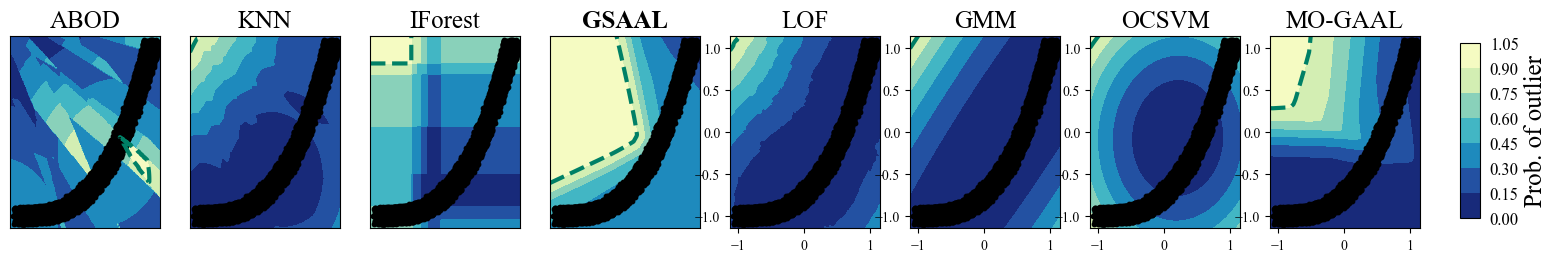

In [110]:
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman']
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1, 8, figsize=(20,2.5))
ax1.contourf(xx, yy, 1-Z_abod, cmap="YlGnBu_r")
ax1.contour(xx,yy,1-Z_abod,levels=[0.9], linestyles = "dashed", cmap = "summer", linewidths=3)
ax1.scatter(X.iloc()[:, 0], X.iloc()[:, 1], s=10,color='black')
ax2.contourf(xx, yy, Z_knn, cmap="YlGnBu_r")
ax2.contour(xx,yy,Z_knn,levels=[0.9], linestyles = "dashed", cmap = "summer", linewidths=3)
ax2.scatter(X.iloc()[:, 0], X.iloc()[:, 1], s=10,color='black')
ax3.contourf(xx, yy, Z_iforest, cmap="YlGnBu_r")
ax3.contour(xx,yy,Z_iforest,levels=[0.9], linestyles = "dashed", cmap = "summer", linewidths=3)
ax3.scatter(X.iloc()[:, 0], X.iloc()[:, 1], s=10,color='black')
im = ax4.contourf(xx, yy, Z_final, cmap="YlGnBu_r")
ax4.contour(xx,yy,Z_final,levels=[0.9], linestyles = "dashed", cmap = "summer", linewidths=3)
ax4.scatter(X.iloc()[:, 0], X.iloc()[:, 1], s=10,color='black')
ax5.contourf(xx, yy, Z_lof, cmap="YlGnBu_r")
ax5.contour(xx,yy,Z_lof,levels=[0.9], linestyles = "dashed", cmap = "summer", linewidths=3)
ax5.scatter(X.iloc()[:, 0], X.iloc()[:, 1], s=10,color='black')
ax6.contourf(xx, yy, Z_gmm, cmap="YlGnBu_r")
ax6.contour(xx,yy,Z_gmm,levels=[0.9], linestyles = "dashed", cmap = "summer", linewidths=3)
ax6.scatter(X.iloc()[:, 0], X.iloc()[:, 1], s=10,color='black')
ax7.contourf(xx, yy, Z_ocsvm, cmap="YlGnBu_r")
ax7.contour(xx,yy,Z_ocsvm,levels=[0.9], linestyles = "dashed", cmap = "summer", linewidths=3)
ax7.scatter(X.iloc()[:, 0], X.iloc()[:, 1], s=10,color='black')
ax8.contourf(xx, yy, 1-Z_mo_gaal, cmap="YlGnBu_r")
ax8.contour(xx,yy,1-Z_mo_gaal,levels=[0.9], linestyles = "dashed", cmap = "summer", linewidths=3)
ax8.scatter(X.iloc()[:, 0], X.iloc()[:, 1], s=10,color='black')
ax1.set_title("ABOD", fontsize=18)
ax2.set_title("KNN", fontsize=18)
ax3.set_title("IForest", fontsize=18)
ax4.set_title(r"GSAAL", fontsize=18, weight='bold')
ax5.set_title("LOF", fontsize=18)
ax6.set_title("GMM", fontsize=18)
ax7.set_title("OCSVM", fontsize=18)
ax8.set_title("MO-GAAL", fontsize=18)

ax1.tick_params(axis='both', which = 'both', bottom = False, top = False, labelbottom = False, right = False, left = False, labelleft = False)
ax2.tick_params(axis='both', which = 'both', bottom = False, top = False, labelbottom = False, right = False, left = False, labelleft = False)
ax3.tick_params(axis='both', which = 'both', bottom = False, top = False, labelbottom = False, right = False, left = False, labelleft = False)
ax4.tick_params(axis='both', which = 'both', bottom = False, top = False, labelbottom = False, right = False, left = False, labelleft = False)
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im,cax = cbar_ax)
cbar.set_label(label = "Prob. of outlier",fontsize = 18)
cbar.ax.tick_params(axis='both', which = 'both', bottom = False, top = False, labelbottom = False, right = False, left = False, labelleft = False)
cbar.ax.tick_params(labelsize=12)
plt.savefig(f"experiments/heatmaps/{name}/{name}_comparison.png",dpi=1200, bbox_inches='tight')
plt.show()
#ABOD - KNN - IForest - GSAAL